In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import os, h5py
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, Input, MaxPooling2D, Activation, LeakyReLU, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

(600, 64, 64) (600, 1)
(150, 64, 64) (150, 1)


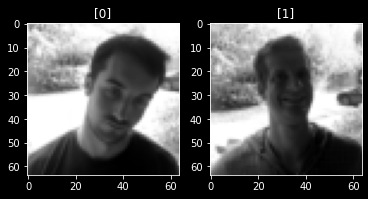

In [5]:
base_path = 'dataset'

# 파일 로드
x_train = np.load(os.path.join(base_path, 'x_train.npy'))
y_train = np.load(os.path.join(base_path, 'y_train.npy'))
x_test = np.load(os.path.join(base_path, 'x_test.npy'))
y_test = np.load(os.path.join(base_path, 'y_test.npy'))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.subplot(1, 2, 1)
plt.title(y_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title(y_train[1])
plt.imshow(x_train[1], cmap='gray')

x_train = x_train.reshape((-1, 64, 64, 1))
x_test = x_test.reshape((-1, 64, 64, 1))
# 무표정 0, 웃음 1

In [6]:
# 데이터 증대
train_datagen = ImageDataGenerator(
    samplewise_center = True, # 픽셀 값의 평균을 0으로
    samplewise_std_normalization = True, # 정규화
    brightness_range = [0.5, 1.5], # 밝기
    zoom_range = [0.8, 1.1], # 확대, 축소
    rotation_range = 15., # 기울기
    channel_shift_range = 25, # 채널 시프트
    horizontal_flip = True # 좌우반전
)

test_datagen = ImageDataGenerator(
    samplewise_center = True, # 픽셀 값의 평균을 0으로
    samplewise_std_normalization = True, # 정규화
)

train_batch_gen = train_datagen.flow(x_train, y_train, batch_size = 16, shuffle = True)
test_batch_gen = test_datagen.flow(x_test, y_test, batch_size = 16, shuffle = False)

In [7]:
def build_model():
    model = Sequential()

    # 흑백 이미지 입력
    input = Input(shape = (64, 64, 1))
    # 컨벌루션 레이어 3개
    output = Conv2D(filters = 32, kernel_size = (3, 3)) (input)
    output = Conv2D(filters = 64, kernel_size = (3, 3)) (output)
    output = Conv2D(filters = 64, kernel_size = (3, 3)) (output)
    # 플랫튼
    output = Flatten() (output)
    # 덴스 레이어 2개, 활성 함수 relu
    output = Dense(128, activation = 'relu') (output)
    output = Dense(64, activation = 'relu') (output)
    # 출력층, 활성 함수 sigmoid
    output = Dense(1, activation = 'sigmoid') (output)

    # 모델 생성
    model = Model(inputs = input, outputs = output)

    # 모델 컴파일, 옵티마이져 adam
    model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['acc'])
    
    return model

model_1 = build_model()
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                                 
 dense (Dense)               (None, 128)               27558016  
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [8]:
# 총 파라미터 2천7백만개
hist_1 = model_1.fit(
    train_batch_gen,
    epochs = 25,
    validation_data = test_batch_gen, # 데이터 리키지의 우려가 조금 있지만 별도 밸리데이션 데이터를 만들지 않고 테스트 데이터를 사용함.
    callbacks = [ # 매 에폭 마다 실행
        # 밸리데이션 정확도를 기준으로 가장 높은 모델을 저장
        ModelCheckpoint('models/happy.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        # 밸리데이션 정확도를 기준으로 5번 이상 개선이 없으면 학습률에 0.2를 곱함. 최소 학습률 0.00001
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 2.4129 - acc: 0.5883
Epoch 00001: val_acc improved from -inf to 0.56000, saving model to models\happy.h5
38/38 [==============================] - 11s 268ms/step - loss: 2.4129 - acc: 0.5883 - val_loss: 1.0236 - val_acc: 0.5600 - lr: 0.0010
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.8710 - acc: 0.6000
Epoch 00002: val_acc improved from 0.56000 to 0.73333, saving model to models\happy.h5
38/38 [==============================] - 10s 266ms/step - loss: 0.8710 - acc: 0.6000 - val_loss: 0.5719 - val_acc: 0.7333 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.6407 - acc: 0.6533
Epoch 00003: val_acc did not improve from 0.73333
38/38 [==============================] - 9s 230ms/step - loss: 0.6407 - acc: 0.6533 - val_loss: 0.5638 - val_acc: 0.6400 - lr: 0.0010
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.5412 - acc: 0.7383
Epoch 00004: val_ac

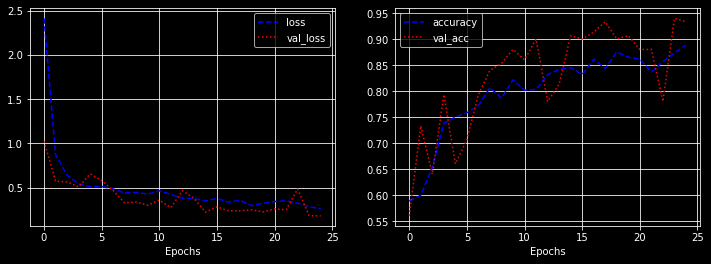

In [9]:
# 학습 결과 출력
hist_1.history.keys()

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_1.history['loss'], 'b--', label='loss')
plt.plot(hist_1.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_1.history['acc'], 'b--', label='accuracy')
plt.plot(hist_1.history['val_acc'], 'r:', label='val_acc')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [26]:
# 테스트셋 예측
y_pred = model_1.predict(test_batch_gen)

# 예측 값 정수로 변환
y_pred_logical = (y_pred > 0.5).astype(int)

test acc: 0.9333333333333333


<AxesSubplot:>

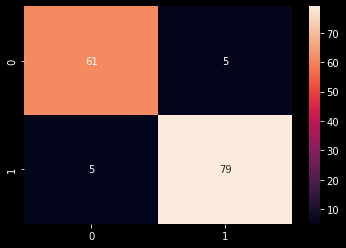

In [29]:
# 테스트셋 정확도 93%
print ('test acc: %s' % accuracy_score(y_test, y_pred_logical))

# 컨퓨젼 메트릭스
cm = confusion_matrix(y_test, y_pred_logical)
sns.heatmap(cm, annot=True)
# x축은 실제 정답
# y축은 예측 값

In [56]:
# 맥스풀링 추가, 활성 함수로 스위쉬 사용
from tensorflow.keras.layers import MaxPool2D

def build_model2():
    model = Sequential()

    # 흑백 이미지 입력
    input = Input(shape = (64, 64, 1))
    # 컨벌루션 레이어 3개, 활성 함수 swish
    output = Conv2D(filters = 32, kernel_size = 3, activation = 'swish') (input)
    output = Conv2D(filters = 64, kernel_size = 3, activation = 'swish') (output)
    output = Conv2D(filters = 64, kernel_size = 3, activation = 'swish') (output)
    # 맥스풀링 레이어 1개
    output = MaxPool2D(strides = (2, 2)) (output)
    
    # 플랫튼
    output = Flatten() (output)
    # 덴스 레이어 2개, 활성 함수 swish
    output = Dense(128, activation = 'swish') (output)
    output = Dense(64, activation = 'swish') (output)
    # 출력층, 활성 함수 sigmoid
    output = Dense(1, activation = 'sigmoid') (output)

    # 모델 생성
    model = Model(inputs = input, outputs = output)

    # 모델 컴파일, 옵티마이져 adam
    model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['acc'])
    
    return model

model_2 = build_model2()
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 64)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 53824)             0         
                                                           

In [57]:
# 총 파라미터 7백만개
hist_2 = model_2.fit(
    train_batch_gen,
    epochs = 25,
    validation_data = test_batch_gen, # 데이터 리키지의 우려가 조금 있지만 별도 밸리데이션 데이터를 만들지 않고 테스트 데이터를 사용함.
    callbacks = [ # 매 에폭 마다 실행
        # 밸리데이션 정확도를 기준으로 가장 높은 모델을 저장
        ModelCheckpoint('models/happy.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        # 밸리데이션 정확도를 기준으로 5번 이상 개선이 없으면 학습률에 0.5를 곱함. 최소 학습률 0.00001
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.7106 - acc: 0.5567
Epoch 00001: val_acc improved from -inf to 0.56667, saving model to models\happy.h5
38/38 [==============================] - 10s 237ms/step - loss: 0.7106 - acc: 0.5567 - val_loss: 0.6314 - val_acc: 0.5667 - lr: 0.0010
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.6155 - acc: 0.6667
Epoch 00002: val_acc improved from 0.56667 to 0.65333, saving model to models\happy.h5
38/38 [==============================] - 8s 222ms/step - loss: 0.6155 - acc: 0.6667 - val_loss: 0.5622 - val_acc: 0.6533 - lr: 0.0010
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.5428 - acc: 0.7000
Epoch 00003: val_acc improved from 0.65333 to 0.68667, saving model to models\happy.h5
38/38 [==============================] - 9s 225ms/step - loss: 0.5428 - acc: 0.7000 - val_loss: 0.5309 - val_acc: 0.6867 - lr: 0.0010
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.53

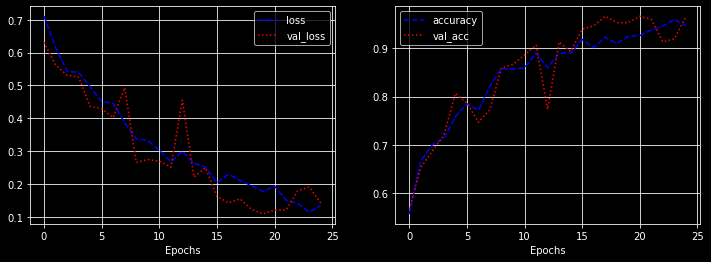

In [60]:
# 학습 결과 출력
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_2.history['loss'], 'b--', label='loss')
plt.plot(hist_2.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_2.history['acc'], 'b--', label='accuracy')
plt.plot(hist_2.history['val_acc'], 'r:', label='val_acc')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [62]:
# 테스트셋 예측
y_pred = model_2.predict(test_batch_gen)

# 예측 값 정수로 변환
y_pred_logical = (y_pred > 0.5).astype(int)

test acc: 0.9666666666666667


<AxesSubplot:>

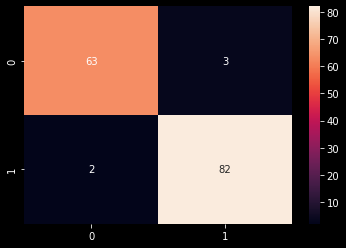

In [63]:
# 테스트셋 정확도 96%
print ('test acc: %s' % accuracy_score(y_test, y_pred_logical))


# 컨퓨젼 메트릭스
cm = confusion_matrix(y_test, y_pred_logical)
sns.heatmap(cm, annot=True)
# x축은 실제 정답
# y축은 예측 값